# How Does Feature Learning Improve Neural Scaling Laws

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns # type: ignore

##### We will go equation by equation and figure by figure, reproducing the results of the paper

### Equation 1

This is simply the ansatz meant to capture scaling of loss with ultimate floor on the loss $\mathcal{L}_\infty$
\begin{align*}
\mathcal{L}(N, t) = c_t t^{-r_t}+c_N N^{-r_N}+\mathcal{L}_\infty
\end{align*}

### Figure 1

The expression for the exponent as a function of $\beta$, the capacity exponent, is 
\begin{align*}
\chi(\beta) = \begin{cases} \frac{2\beta}{1+\beta} & 0 < \beta < 1 \\ \beta & 1 < \beta  \end{cases}
\end{align*}

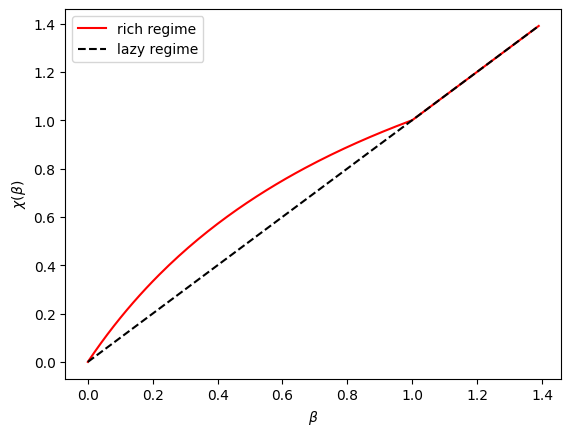

In [2]:
def chi(beta):
    return beta*max(1, 2/(1+beta))

beta = [b for b in np.arange(0, 1.4, .01)]
chiy = [chi(b) for b in beta]

plt.plot(beta, chiy, color = "red", label = "rich regime")
plt.plot(beta, beta, "k--", label = "lazy regime")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\chi(\beta)$")
plt.legend()
plt.show()

### Equation 2

We are going to create a randomized initialization of the following model.  We require $M$ orthogonal eigenfunctions $\psi_M$, with an inner product that defines the associated kernel
\begin{align*}
K(x, x') = \langle \psi_M(x) \cdot \psi_M(x') \rangle
\end{align*} 
which is diagonal
\begin{align*}
K = \text{diag}(\lambda_1, \dots, \lambda_M)
\end{align*}
we want these eigenvalues to have a power law falloff 
\begin{align*}
\lambda_k \sim k^{-\alpha}
\end{align*}
with exponent $\alpha$ called the capacity.

We are going to train in an $N$ parameter space $\tilde \psi(x, t) \in \mathbb{R}^N$. This can be captured by a projection matrix $A(t) \in \mathbb{R}^{N \times M}$ and the model can be summarized as 
\begin{align*}
f(x, t) = \frac{1}{N}w(t)\cdot \tilde \psi(x, t),& \hspace{7mm} \tilde \psi(x, t) = A(t)\psi(x)\\
&y(x) = w^* \cdot \psi(x)
\end{align*}

We can first initialize this model by forgetting about $x$ space and considering features $\psi_\infty$ drawn from an $M$-dimensional Gaussian with the desired spectral properties.

We have constructed this distribution from which to sample feature-mapped data points $\psi_\infty$ to obey the power law spectral fallof with capacity exponent $\alpha$. Now, we need to choose a target set of weights $w^\star$ which obey the source condition 
\begin{align*}
\sum\limits_{l > k } \lambda_l (w^\star_l)^2 \sim \lambda_k^{-\beta} 
\end{align*}

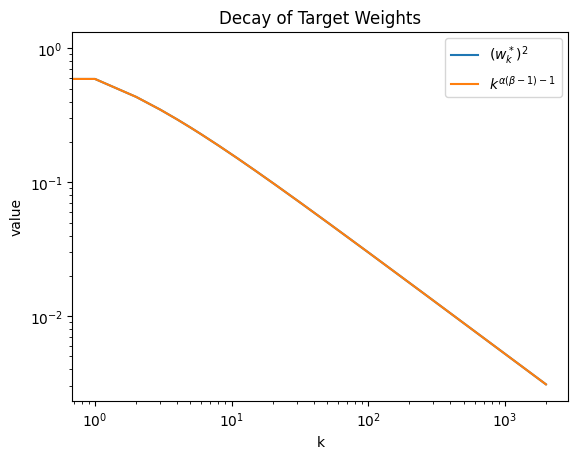

In [4]:
def gen_lambda(M, alpha):
    return torch.diag(torch.tensor([ k**(-alpha) for k in range(1, M+1)]))



alpha = 1.2
beta = 1.2
M = 2000
P = int(1e5) #number of samples
dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M), gen_lambda(M, alpha))
lambdavals = torch.tensor([ k**(-alpha) for k in range(1, M+1)])
wstk = torch.tensor([ (1)*np.sqrt(k)**((alpha*(beta-1)-1)) for k in range(1, M+1)]).to(torch.float32)
plt.loglog(wstk**2, label = r"$(w^*_k)^2$")
plt.loglog([k**(alpha*(beta-1)-1) for k in range(1, M+1)], label = r"$k^{\alpha(\beta-1)-1}$")
plt.legend()
plt.xlabel("k")
plt.ylabel("value")
plt.title("Decay of Target Weights")
plt.show()


In [5]:
wstdotlambda = torch.stack([sum(torch.cat((torch.zeros(m), lambdavals[m:]))*wstk**2) for m in range(M)])

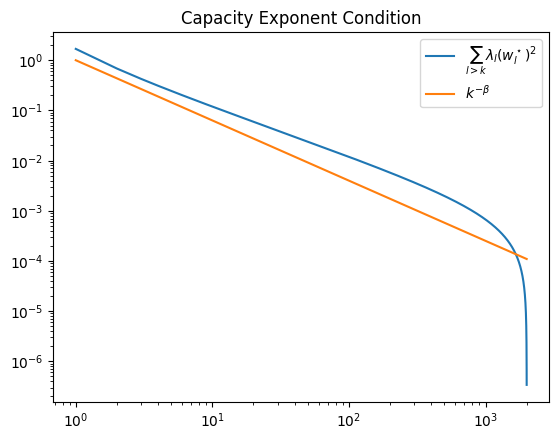

In [6]:
plt.loglog(range(1, M+1), wstdotlambda, label=r"$\sum_{l > k} \lambda_l (w^\star_l)^2$")
plt.loglog(range(1, M+1), [k**(-(beta)) for k in range(1, M+1)], label=r"$k^{-\beta}$")
plt.legend()
plt.title("Capacity Exponent Condition")
plt.show()

We have generated an input spectrum and a target function obeying the desired source and capacity conditions.  Now we can setup model training.

In [7]:
PSI = dist.sample((P, ))
PSI.shape

torch.Size([100000, 2000])

### Training

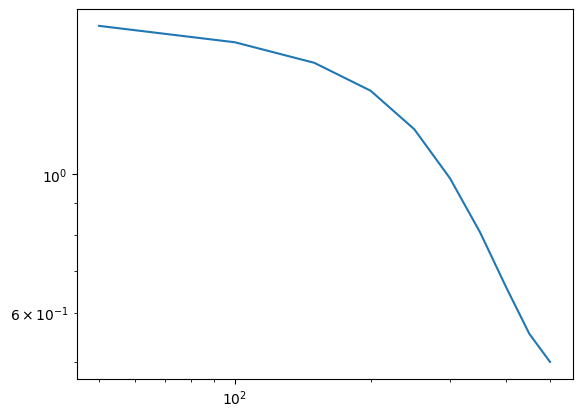

In [18]:
N = 1500
B = 32
Tsteps = 500
eta, gamma = 7e-4, 1e-1
A = torch.randn((N, M))
A0, At = A.clone(), A.clone()
wt = torch.rand((N, 1))

def f(psi):
    return 1/N * wt.T @ A @ psi.T 

def y(psi):
    return wstk.view((M, 1)).T @ psi.T

def loss(psi):
    return torch.mean((f(psi)[0]- y(psi)[0])**2)

loss_list = []
tlist = []
i, running =0, 0
for t in range(Tsteps):
    v0 = wstk.view((M, 1))- (A.T @ wt /N) 
    wt1 = wt+eta*At@(PSI[t*B:(t+1)*B].T @PSI[t*B:(t+1)*B]/B)@v0
    At1 = At+eta*gamma*(wt @ v0.T)@(PSI[t*B:(t+1)*B].T @ PSI[t*B:(t+1)*B]/B) @ (A0.T @ A0)
    wt, At = wt1.clone(), At1.clone()
    running += loss(PSI[-B:])/50
    i+= 1
    if i%50 == 0:
        tlist.append(i)
        loss_list.append(running)
        running = 0


plt.plot(tlist, loss_list)
plt.xscale('log')
plt.yscale('log')
plt.show()
    

